# Setting Up

### Import libraries

In [2]:
'''Trains a simple convnet on the MNIST dataset.

Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)
set_session(sess)
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras import backend as K
from keras.models import model_from_json

import os
from json import loads, dumps

Using TensorFlow backend.


### Define Hyperparameters and Paths

In [3]:
save_dir = "saved_models"
weights_name = "mnist_saved_weights_f2.h5"
model_json_name = "mnist_saved_f2.json"
batch_size = 64
num_classes = 10
epochs = 12
lr = 0.001

# input image dimensions
img_rows, img_cols = 28, 28

# Data Loading and Processing

### Load Data

In [4]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

### Pre-Processing

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalisation
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# Build Neural Network

In [6]:
inputs = Input(shape=input_shape)
x = Conv2D(32, kernel_size=(3, 3),
                 activation='relu')(inputs)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.75)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=predictions)

# Define Optimiser
opt = SGD(lr=lr)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

# Train

In [7]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 7s 120us/step - loss: 2.1817 - acc: 0.2393 - val_loss: 1.8360 - val_acc: 0.7201
Epoch 2/12
60000/60000 [==============================] - 4s 72us/step - loss: 1.4935 - acc: 0.5147 - val_loss: 0.7571 - val_acc: 0.8412
Epoch 3/12
60000/60000 [==============================] - 4s 73us/step - loss: 0.9965 - acc: 0.6751 - val_loss: 0.4930 - val_acc: 0.8797
Epoch 4/12
60000/60000 [==============================] - 4s 73us/step - loss: 0.8364 - acc: 0.7288 - val_loss: 0.4072 - val_acc: 0.8947
Epoch 5/12
60000/60000 [==============================] - 4s 73us/step - loss: 0.7489 - acc: 0.7594 - val_loss: 0.3597 - val_acc: 0.9036
Epoch 6/12
60000/60000 [==============================] - 4s 73us/step - loss: 0.6957 - acc: 0.7782 - val_loss: 0.3376 - val_acc: 0.9087
Epoch 7/12
60000/60000 [==============================] - 4s 73us/step - loss: 0.6617 - acc: 0.7915 - val_loss: 0.3167 - val_ac

# Save and Load Models

### Save Model and Weights

In [ ]:
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)

# Model Definition to JSON
model_json = model.to_json()
with open(model_json_name, 'w') as json_file:
        json_file.write(model_json)

# Save Model Weights
weights_path = os.path.join(save_dir, weights_name)
model.save_weights(weights_path)

print('Saved trained weights at %s ' % weights_path)

### Load Saved Model and Weights

In [ ]:
# Load Model
json_file = open(model_json_name, 'r')
loaded_model_json = json_file.read()
json_file.close()
model_def_json = loads(loaded_model_json)

# Load Weights
weights_path = os.path.join(save_dir, weights_name)
loaded_model.load_weights(weights_path)

# Compile Model
opt = SGD(lr=lr)
loaded_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

# Evaluation

### Keras Eval Function

In [8]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.261199447113
Test accuracy: 0.9269


## ROC Curve

In [27]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [18]:
# Plot linewidth.
lw = 2
n_classes = 10

In [19]:
y_score = model.predict(x_test)

In [20]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [21]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [22]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

### Plot ROC Curves

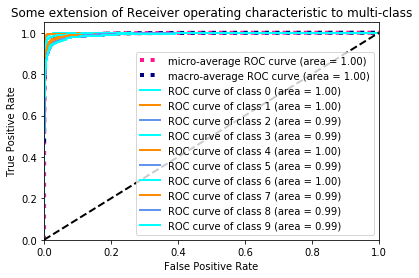

In [23]:
# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

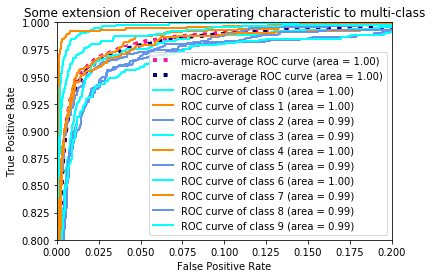

In [24]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## AUC

In [25]:
roc_auc["macro"]

0.99526939802695724